In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Wed Jan  5 16:10:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.47       Driver Version: 472.47       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           TCC  | 00000000:07:00.0 Off |                  N/A |
| N/A   49C    P8    N/A /  N/A |     10MiB / 11448MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           TCC  | 00000000:08:00.0 Off |                  N/A |
| N/A   

In [1]:
import utils
from Constant import *
import nets
import numpy as np
import json
import time
import IPython.display as ipd
import tensorflow as tf
from importlib import reload
from scipy.io.wavfile import write

In [60]:
reload(nets)

<module 'nets' from 'C:\\jup\\text_to_voice\\nets.py'>

In [1]:
reload(utils)

NameError: name 'reload' is not defined

In [17]:
mels = np.load('numpy/mels.npy')
mags = np.load('numpy/mags.npy')

In [18]:
print(np.amax(mags), np.amax(mels), np.amin(mels))

42.151325 12.051643 -100.0


In [3]:
mels = np.where((mels < 1) & (mels > -1), mels *0, mels)
mags = np.where((mags < 1) & (mags > -1), mags *0, mags)

In [19]:
mels = (mels + 100) / 112.051643
mags = (mags + 100) / 142.151325

In [5]:
mels = tf.keras.layers.AveragePooling1D(pool_size=4, strides=4, padding='valid')(mels)

In [24]:
mels = np.clip(mels, 1e-5, 1- 1e-5)
mags = np.clip(mags, 1e-5, 1- 1e-5)

In [41]:
mags.shape

(8481, 316, 513)

In [9]:
mels.shape

(8481, 316, 80)

In [6]:
with open('numpy/X_train.txt') as json_file:
    X_train_txt = json.load(json_file)

In [7]:
tokenizer, X_train_seq, vocabularySize = utils.text_to_token(X_train_txt, utils.len_of_inp(X_train_txt))

Время обработки: 0.42c
[('unknown', 1), ('start', 2), ('end', 3), ('и', 4), ('в', 5), ('не', 6), ('на', 7), ('что', 8), ('я', 9), ('он', 10), ('с', 11), ('а', 12), ('это', 13), ('но', 14), ('его', 15), ('как', 16), ('по', 17), ('к', 18), ('она', 19), ('за', 20)]
Размер словаря 12527
<start> житель квартала сказал бы <end>
[   2 3153 3154   48   35    3    0    0    0    0    0    0    0    0
    0    0    0    0]
Размер предложения <built-in function len>


In [25]:
X_train, X_test = X_train_seq[:int(len(X_train_seq)*0.9)], X_train_seq[int(len(X_train_seq)*0.9):]
mels_train, mels_test = mels[:int(len(X_train_seq)*0.9)], mels[int(len(X_train_seq)*0.9):]
mags_train, mags_test = mags[:int(len(X_train_seq)*0.9)], mags[int(len(X_train_seq)*0.9):]

In [33]:
mels  = np.reshape(mels, (-1, 80))
mags = np.reshape(mags,(-1, 513))

In [45]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [75]:
BUFFER_SIZE = len(X_train)
steps_per_epoch = len(X_train)//batch_size

dataset = tf.data.Dataset.from_tensor_slices((X_train, mels_train)).shuffle(batch_size)
dataset = dataset.batch(batch_size, drop_remainder=True)

In [44]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')

In [64]:
tf.config.experimental.reset_memory_stats('GPU:0')

In [40]:
reload(nets)

<module 'nets' from 'C:\\jup\\text_to_voice\\nets.py'>

In [17]:
m_m = nets.create_m_m(513, 80)

In [25]:
m_m.load_weight('weights/8/mm')

AttributeError: 'Functional' object has no attribute 'load_weight'

In [2]:
m_m = tf.keras.models.load_model('weights/got/mm')

In [10]:
m_m.compile(tf.keras.optimizers.Adam(learning_rate=0.000001),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=['accuracy'])

In [34]:
m_m.fit(mels, mags, shuffle=True, epochs=10000,
        batch_size=512,

        verbose=1
        ) #callbacks=[reduce_lr]

Epoch 1/10000
4504/4504 [==============================] - 107s 24ms/step - loss: 0.0017 - accuracy: 0.1036
Epoch 2/10000
4504/4504 [==============================] - 116s 26ms/step - loss: 0.0017 - accuracy: 0.1036
Epoch 3/10000
4504/4504 [==============================] - 99s 22ms/step - loss: 0.0016 - accuracy: 0.1038
Epoch 4/10000
4504/4504 [==============================] - 116s 26ms/step - loss: 0.0016 - accuracy: 0.1038
Epoch 5/10000
4504/4504 [==============================] - 99s 22ms/step - loss: 0.0016 - accuracy: 0.1039
Epoch 6/10000
4504/4504 [==============================] - 116s 26ms/step - loss: 0.0016 - accuracy: 0.1038
Epoch 7/10000
4504/4504 [==============================] - 99s 22ms/step - loss: 0.0016 - accuracy: 0.1038
Epoch 8/10000
4504/4504 [==============================] - 116s 26ms/step - loss: 0.0016 - accuracy: 0.1044
Epoch 9/10000
4504/4504 [==============================] - 100s 22ms/step - loss: 0.0016 - accuracy: 0.1043
Epoch 10/10000
4504/4504 [=====

InternalError: Could not synchronize CUDA stream: CUDA_ERROR_UNKNOWN: unknown error

In [35]:
m_m.save_weights('weights/got/mm')
m_m.save('weights/got/mm')

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run Identity: stream did not block host until done; was already in an error state [Op:Identity]

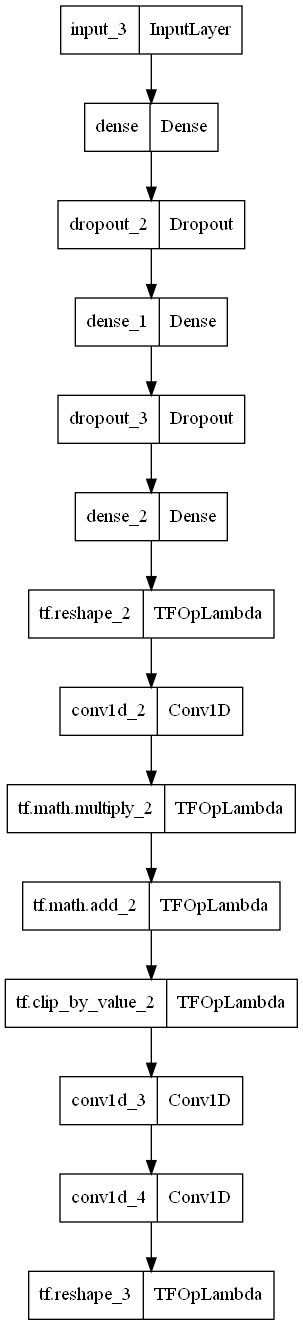

In [14]:
tf.keras.utils.plot_model(m_m, to_file='m_m.png', show_layer_names=True)

In [69]:
reload(nets)

<module 'nets' from 'C:\\jup\\text_to_voice\\nets.py'>

In [23]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=30)

In [8]:
enc = tf.keras.models.load_model('weights/got/enc')

In [5]:
enc = nets.create_encoder2(vocabularySize, e, 80, 316,  utils.len_of_inp(X_train_txt))


NameError: name 'vocabularySize' is not defined

In [12]:
enc.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=['accuracy'])

In [28]:
history = enc.fit(X_train, mels_train, shuffle=True, epochs=20000,
        batch_size=32,
        validation_data=(X_test,mels_test),
        verbose=1
        ) #callbacks=[reduce_lr]

Epoch 1/20000
206/206 [==============================] - 50s 239ms/step - loss: 0.0033 - accuracy: 0.1046 - val_loss: 0.0256 - val_accuracy: 0.0917
Epoch 2/20000
206/206 [==============================] - 50s 241ms/step - loss: 0.0032 - accuracy: 0.1034 - val_loss: 0.0257 - val_accuracy: 0.0907
Epoch 3/20000
206/206 [==============================] - 47s 229ms/step - loss: 0.0032 - accuracy: 0.1024 - val_loss: 0.0257 - val_accuracy: 0.0893
Epoch 4/20000
206/206 [==============================] - 50s 242ms/step - loss: 0.0032 - accuracy: 0.1011 - val_loss: 0.0256 - val_accuracy: 0.0886
Epoch 5/20000
206/206 [==============================] - 49s 236ms/step - loss: 0.0032 - accuracy: 0.1014 - val_loss: 0.0255 - val_accuracy: 0.0922
Epoch 6/20000
206/206 [==============================] - 48s 233ms/step - loss: 0.0032 - accuracy: 0.1025 - val_loss: 0.0255 - val_accuracy: 0.0928
Epoch 7/20000
206/206 [==============================] - 50s 241ms/step - loss: 0.0032 - accuracy: 0.1033 - val_

KeyboardInterrupt: 

In [15]:
enc.save_weights('weights/got/enc')
enc.save('weights/got/enc')

INFO:tensorflow:Assets written to: weights/8/enc\assets


INFO:tensorflow:Assets written to: weights/8/enc\assets


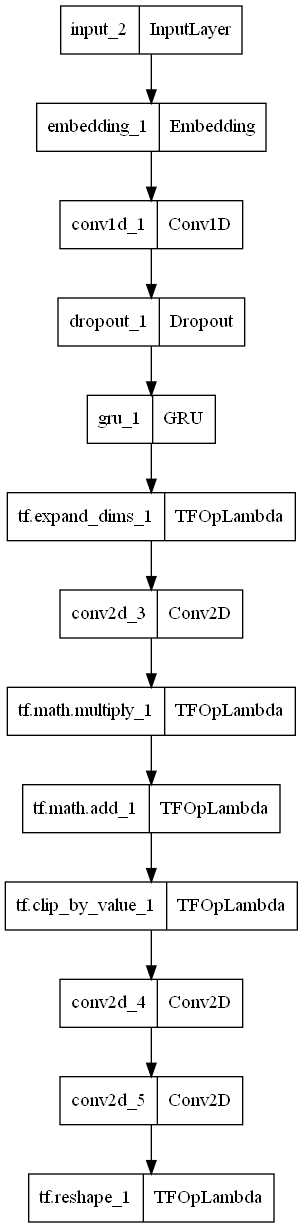

In [13]:
tf.keras.utils.plot_model(enc, to_file='enc.png', show_layer_names=True)

In [13]:
wav = utils.sintezis2(['<start> она сказала привет <end>'], utils.len_of_inp(X_train_txt), tokenizer, enc, m_m, 513, 44.16127)

UnimplementedError:  The Conv2D op currently only supports the NHWC tensor format on the CPU. The op was given the format: NCHW
	 [[node model_1/conv1d_1/Conv1D
 (defined at C:\Users\Tomas\anaconda3\lib\site-packages\keras\layers\convolutional.py:231)
]] [Op:__inference_predict_function_25239]

Errors may have originated from an input operation.
Input Source operations connected to node model_1/conv1d_1/Conv1D:
In[0] model_1/conv1d_1/Conv1D/ExpandDims:	
In[1] model_1/conv1d_1/Conv1D/ExpandDims_1:

Operation defined at: (most recent call last)
>>>   File "C:\Users\Tomas\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\Tomas\AppData\Local\Temp/ipykernel_2176/132922260.py", line 1, in <module>
>>>     wav = utils.sintezis2(['<start> она сказала привет <end>'], utils.len_of_inp(X_train_txt), tokenizer, enc, m_m, 513, 44.16127)
>>> 
>>>   File "D:\jup\text_to_voice\utils.py", line 184, in sintezis2
>>>     mels = enc.predict(np.reshape(inp, (1,input_len)))
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\engine\training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\engine\training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\engine\training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\engine\training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 246, in call
>>>     outputs = self.convolution_op(inputs, self.kernel)
>>> 
>>>   File "C:\Users\Tomas\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 231, in convolution_op
>>>     return tf.nn.convolution(
>>> 

In [77]:
reload(utils)

<module 'utils' from 'C:\\jup\\text_to_voice\\utils.py'>

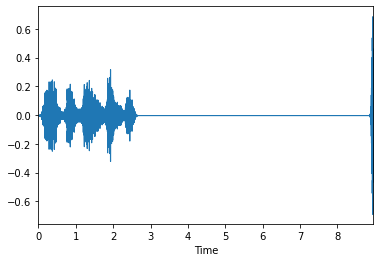

In [30]:
from librosa import display
display.waveplot(wav, sr=9000)

In [32]:
ipd.Audio(wav, rate=16000)

In [140]:
ipd.Audio(wav, rate=16000)

In [134]:
print('hi')

hi


In [138]:
ipd.Audio(wav, rate=16000)

In [68]:
x = tf.random.normal((4, 10, 200, 1))
y = tf.random.normal((4, 1, 10, 18))
x = tf.keras.layers.SeparableConv2D(101, 3, strides=(1, 1),
                                     padding='same', data_format='channels_last')(x)
tf.keras.layers.SeparableConv2D(1, 3, strides=(1, 1),
                                padding='same', data_format='channels_first')(x)

<tf.Tensor: shape=(4, 1, 200, 101), dtype=float32, numpy=
array([[[[ 1.45104481e-02,  3.73750296e-03,  2.99699511e-02, ...,
           4.57697921e-02, -2.13128440e-02, -2.08519567e-02],
         [-1.80411655e-02,  2.12850440e-02, -2.25289930e-02, ...,
           7.33670294e-02,  1.38687510e-02,  4.26281951e-02],
         [-6.56287698e-03, -9.47879162e-03,  8.04119371e-03, ...,
          -1.13855191e-02, -2.83207209e-03,  2.11468022e-02],
         ...,
         [-1.31030064e-02,  6.07900601e-03, -9.65187326e-02, ...,
          -1.33136660e-01,  6.14126585e-02, -2.31966637e-02],
         [ 7.99904019e-03,  1.92631632e-02,  1.11063346e-02, ...,
           8.33766088e-02, -1.06335375e-02, -1.01814074e-02],
         [-5.25144534e-03, -4.78425585e-02,  8.78572538e-02, ...,
          -1.71933044e-02, -4.78500202e-02,  5.80556206e-02]]],


       [[[-4.22297651e-03, -6.24899007e-03, -7.21888198e-03, ...,
          -3.09913233e-02,  5.94387203e-03,  5.59645658e-03],
         [-2.39373161e-03, -

In [11]:
a = np.array([[0, 1, 2],
              [0, 2, 4],
              [0, 3, 6]])

In [6]:
cond = a <4

In [13]:
np.where((a < 4) & ( a>2 ), a + 1000, a*0)

array([[   0,    0,    0],
       [   0,    0,    0],
       [   0, 1003,    0]])

In [144]:
write('wav/1.wav', 16000, wav)

In [99]:
import librosa
y, sr = librosa.load('aud/asr_calls_2_val/1/0a/154bb640da1f.wav')
spectrogram = librosa.stft(y=y,
                           n_fft=n_fft,
                           hop_length=hop_length,
                           win_length=win_length)

In [ ]:
sr

In [97]:
np.amin(y)

-0.038085938

In [78]:
x= np.append(y, np.zeros((14245 - len(y), 1)))

In [79]:
x[-20:-1]

array([ 7.08007812e-03,  6.98852539e-03,  6.62231445e-03,  6.13403320e-03,
        5.52368164e-03,  4.79125977e-03,  4.11987305e-03,  3.41796875e-03,
        2.74658203e-03,  2.07519531e-03,  1.43432617e-03,  8.85009766e-04,
        3.96728516e-04,  6.10351562e-05, -2.44140625e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [4]:
np.amin(spectrogram)

(-4.795121+0.7897756j)

In [6]:
wav = utils.spectrogram2wav(mags[0], 44.16127)